The purpose of this notebook is to test several machine learning models in our problem, trying to improve the TiC-Onco risk score results. 

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils import test_model, test_model_bootstrap

In [3]:
SEED = 1997 # for reproducibility

In [4]:
# reading data
path = 'data/'
data = pd.read_csv(path + 'data_TiC_Onco.csv')
X = data[data.columns.difference(['id','VTE','khorana'])]
y = data['VTE']
khorana = data['khorana']

X.shape, y.shape

((391, 9), (391,))

In [5]:
X.head()

,Family,bmi,estadiGrup,rs2232698,rs4524,rs5985,rs6025,tipusTumor_HR,tipusTumor_VHR
0,0,1,1,0,1,1,0,0,0
1,0,0,0,0,1,0,0,0,1
2,0,0,1,0,2,0,0,1,0
3,0,0,1,0,2,0,0,0,0
4,0,1,1,0,2,0,0,0,0


In [6]:
y.value_counts() 

0    318
1     73
Name: VTE, dtype: int64

### Baseline model (Logistic Regression)

In [7]:
lr = LogisticRegression(solver='liblinear', random_state=SEED)

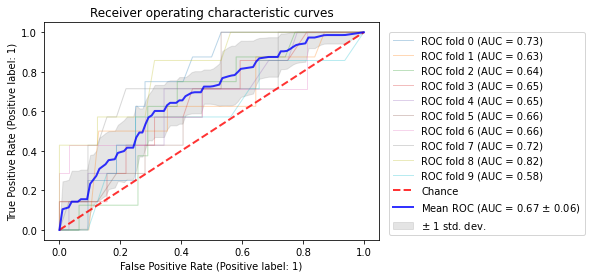

,score,mean,95% CI
0,AUC,0.67,"(0.55,0.8)"
1,accuracy,0.72,"(0.64,0.8)"
2,sensitivity,0.34,"(0.09,0.6)"
3,specificity,0.81,"(0.73,0.88)"
4,PPV,0.29,"(0.11,0.46)"
5,NPV,0.84,"(0.78,0.9)"


In [9]:
test_model(lr, X, y)

### Scaling data

In [10]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

scaler_std = StandardScaler()
X_scaled_std = scaler_std.fit_transform(X)

### Tunning Logistic Regression

In [13]:
lr = Pipeline([('LR',LogisticRegression(solver='liblinear', max_iter=10000, random_state=SEED))])

params_lr = {'LR__penalty': ['l1','l2'], 'LR__C': np.logspace(-4, 4, 50), 
          'LR__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_lr = GridSearchCV(lr, params_lr, scoring='roc_auc', cv=10, n_jobs=2)
gs_lr.fit(X,y)
gs_lr.best_params_

{'LR__C': 0.0062505519252739694,
 'LR__class_weight': {1: 8},
 'LR__penalty': 'l2'}

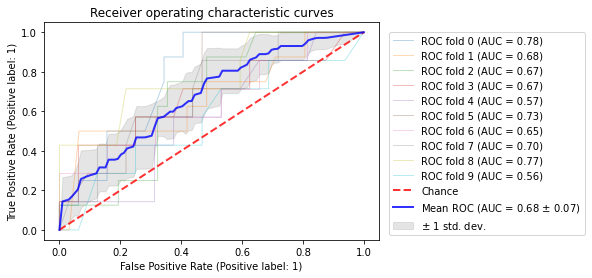

,score,mean,95% CI
0,AUC,0.68,"(0.54,0.82)"
1,accuracy,0.72,"(0.65,0.78)"
2,sensitivity,0.34,"(0.08,0.6)"
3,specificity,0.80,"(0.75,0.86)"
4,PPV,0.28,"(0.08,0.47)"
5,NPV,0.84,"(0.79,0.9)"


In [14]:
test_model(gs_lr.best_estimator_, X, y)

Adding MinMaxScaler:

In [15]:
lr = Pipeline([('scaler',MinMaxScaler()), ('LR',LogisticRegression(solver='liblinear', max_iter=10000, random_state=SEED))])

params_lr = {'LR__penalty': ['l1','l2'], 'LR__C': np.logspace(-4, 4, 50), 
          'LR__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_lr = GridSearchCV(lr, params_lr, scoring='roc_auc', cv=10, n_jobs=2)
gs_lr.fit(X,y)
gs_lr.best_params_

{'LR__C': 0.0020235896477251557,
 'LR__class_weight': {1: 10},
 'LR__penalty': 'l2'}

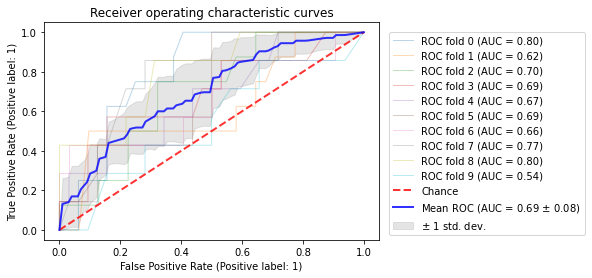

,score,mean,95% CI
0,AUC,0.69,"(0.54,0.85)"
1,accuracy,0.75,"(0.66,0.83)"
2,sensitivity,0.44,"(0.13,0.75)"
3,specificity,0.82,"(0.7,0.94)"
4,PPV,0.37,"(0.14,0.6)"
5,NPV,0.87,"(0.8,0.93)"


In [16]:
test_model(gs_lr.best_estimator_, X, y)

### LinearSVC

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions.

In [17]:
lin_svc = Pipeline([('LinearSVC',LinearSVC(random_state=SEED, max_iter=10000, dual=False))])

params_lin_svc = {'LinearSVC__penalty': ['l1','l2'], 'LinearSVC__C': np.logspace(-4, 4, 50), 
          'LinearSVC__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_lin_svc = GridSearchCV(lin_svc, params_lin_svc, scoring='roc_auc', cv=10, n_jobs=2)
gs_lin_svc.fit(X,y)
gs_lin_svc.best_params_

{'LinearSVC__C': 0.009102981779915217,
 'LinearSVC__class_weight': {1: 8},
 'LinearSVC__penalty': 'l1'}

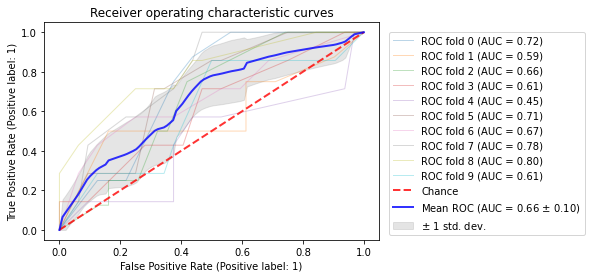

,score,mean,95% CI
0,AUC,0.66,"(0.46,0.86)"
1,accuracy,0.72,"(0.65,0.78)"
2,sensitivity,0.39,"(0.01,0.77)"
3,specificity,0.79,"(0.69,0.89)"
4,PPV,0.28,"(0.13,0.44)"
5,NPV,0.85,"(0.77,0.93)"


In [18]:
test_model(gs_lin_svc.best_estimator_, X, y)

In [19]:
lin_svc = Pipeline([('scaler',MinMaxScaler()), ('LinearSVC',LinearSVC(random_state=SEED, max_iter=10000, dual=False))])

params_lin_svc = {'LinearSVC__penalty': ['l1','l2'], 'LinearSVC__C': np.logspace(-4, 4, 50), 
          'LinearSVC__class_weight': [{1:0.5},{1:1},{1:5},{1:8},{1:10},{1:15},{1:20}]}


gs_lin_svc = GridSearchCV(lin_svc, params_lin_svc, scoring='roc_auc', cv=10, n_jobs=2)
gs_lin_svc.fit(X,y)
gs_lin_svc.best_params_

{'LinearSVC__C': 0.00014563484775012445,
 'LinearSVC__class_weight': {1: 8},
 'LinearSVC__penalty': 'l2'}

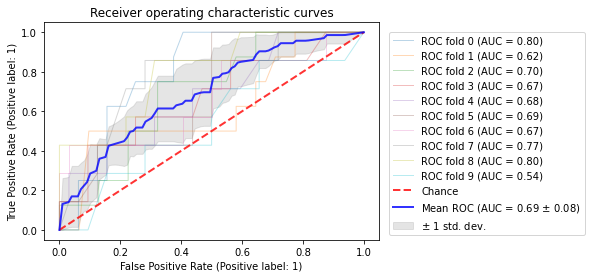

,score,mean,95% CI
0,AUC,0.69,"(0.54,0.84)"
1,accuracy,0.75,"(0.66,0.83)"
2,sensitivity,0.42,"(0.13,0.72)"
3,specificity,0.82,"(0.7,0.94)"
4,PPV,0.37,"(0.14,0.6)"
5,NPV,0.86,"(0.8,0.92)"


In [20]:
test_model(gs_lin_svc.best_estimator_, X, y)

### KNN Classifier

In [21]:
knn = Pipeline([('KNN',KNeighborsClassifier())])

params_knn = {'KNN__n_neighbors': np.linspace(3,299,num=75,dtype=int), 'KNN__weights': ['uniform','distance'], 
          'KNN__p': [1,2,3,4,5]}


gs_knn = GridSearchCV(knn, params_knn, scoring='roc_auc', cv=10, n_jobs=2)
gs_knn.fit(X,y)
gs_knn.best_params_

{'KNN__n_neighbors': 163, 'KNN__p': 1, 'KNN__weights': 'uniform'}

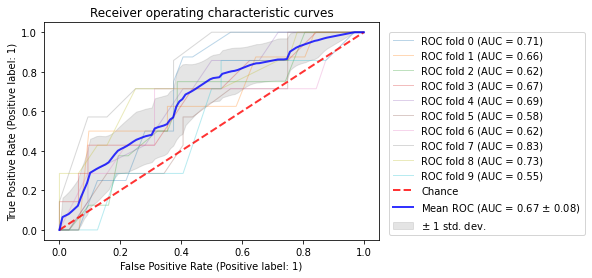

,score,mean,95% CI
0,AUC,0.67,"(0.51,0.82)"
1,accuracy,0.72,"(0.63,0.8)"
2,sensitivity,0.40,"(0.21,0.59)"
3,specificity,0.79,"(0.71,0.87)"
4,PPV,0.30,"(0.15,0.46)"
5,NPV,0.85,"(0.8,0.9)"


In [22]:
test_model(gs_knn.best_estimator_, X, y)

In [11]:
knn = Pipeline([('scaler',MinMaxScaler()), ('KNN',KNeighborsClassifier())])

params_knn = {'KNN__n_neighbors': np.linspace(3,299,num=75,dtype=int), 'KNN__weights': ['uniform','distance'], 
          'KNN__p': [1,2,3,4,5]}


gs_knn = GridSearchCV(knn, params_knn, scoring='roc_auc', cv=10, n_jobs=2)
gs_knn.fit(X,y)
gs_knn.best_params_

{'KNN__n_neighbors': 219, 'KNN__p': 2, 'KNN__weights': 'uniform'}

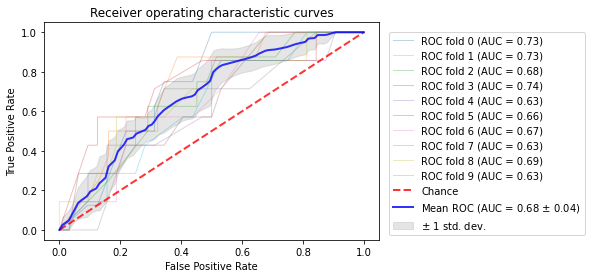

,score,mean,95% CI
0,AUC,0.68,"(0.6,0.76)"
1,accuracy,0.73,"(0.69,0.77)"
2,sensitivity,0.37,"(0.11,0.63)"
3,specificity,0.81,"(0.77,0.84)"
4,PPV,0.30,"(0.15,0.44)"
5,NPV,0.85,"(0.8,0.9)"


In [12]:
test_model(gs_knn.best_estimator_, X, y)

### Support Vector Machine

In [23]:
svc = Pipeline([('scaler',MinMaxScaler()), ('SVC',SVC(probability=True, random_state=SEED))])

params_svc = {'SVC__C': np.logspace(-4, 4, 20), 'SVC__kernel': ['poly','rbf'], 'SVC__degree': [2,3,5],
          'SVC__class_weight': [{1:1},{1:5},{1:8},{1:10}]}


gs_svc = GridSearchCV(svc, params_svc, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_svc.fit(X,y)
gs_svc.best_params_

Fitting 10 folds for each of 480 candidates, totalling 4800 fits


{'SVC__C': 0.004832930238571752,
 'SVC__class_weight': {1: 5},
 'SVC__degree': 2,
 'SVC__kernel': 'rbf'}

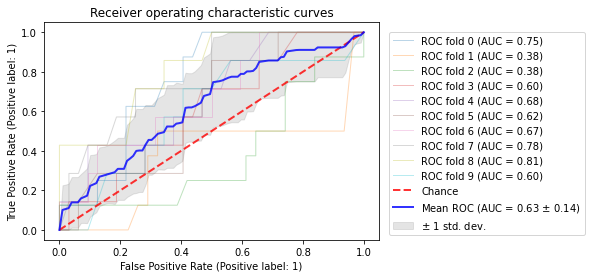

,score,mean,95% CI
0,AUC,0.63,"(0.34,0.91)"
1,accuracy,0.71,"(0.62,0.79)"
2,sensitivity,0.28,"(0,0.6)"
3,specificity,0.81,"(0.73,0.88)"
4,PPV,0.23,"(0.02,0.45)"
5,NPV,0.83,"(0.75,0.91)"


In [24]:
test_model(gs_svc.best_estimator_, X, y)

## Ensemble methods

### Bagging classifier

In [ ]:
bagging = Pipeline([('Bagging',BaggingClassifier(random_state=SEED))])

params_bagging = {'Bagging__base_estimator': [DecisionTreeClassifier(random_state=SEED)], 
                  'Bagging__n_estimators': [5,10,20,30,40,50], 'Bagging__max_samples': [0.5,0.8,1.0],
                  'Bagging__max_features': [0.5,0.8,1.0]}


gs_bagging = GridSearchCV(bagging, params_bagging, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_bagging.fit(X,y)
gs_bagging.best_params_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 300 tasks      | elapsed:   11.0s
[Parallel(n_jobs=2)]: Done 540 out of 540 | elapsed:   20.3s finished


{'Bagging__base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1997, splitter='best'),
 'Bagging__max_features': 0.5,
 'Bagging__max_samples': 0.8,
 'Bagging__n_estimators': 10}

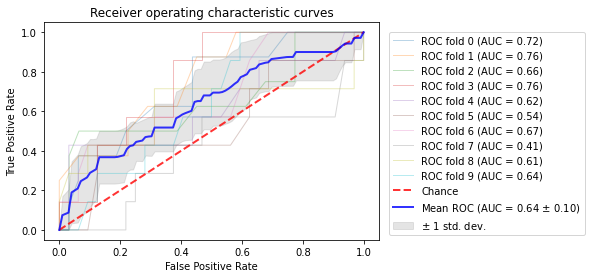

,score,mean,95% CI
0,AUC,0.64,"(0.44,0.84)"
1,accuracy,0.72,"(0.66,0.78)"
2,sensitivity,0.37,"(0.1,0.63)"
3,specificity,0.80,"(0.76,0.84)"
4,PPV,0.29,"(0.08,0.5)"
5,NPV,0.85,"(0.8,0.9)"


In [ ]:
test_model(gs_bagging.best_estimator_, X, y)

Using Linear SVC as base estimator: bad performance ~ 0.55

Using Logistic Regression as base estimator:

In [20]:
base = gs_lr.best_estimator_
bagging = Pipeline([('Bagging',BaggingClassifier(base_estimator=base, random_state=SEED))])

params_bagging = {'Bagging__n_estimators': [5,10,20,30,40,50], 'Bagging__max_samples': [0.5,0.8,1.0],
                  'Bagging__max_features': [0.5,0.8,1.0]}


gs_bagging = GridSearchCV(bagging, params_bagging, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_bagging.fit(X,y)
gs_bagging.best_params_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 140 tasks      | elapsed:   12.8s
[Parallel(n_jobs=2)]: Done 386 tasks      | elapsed:   37.1s
[Parallel(n_jobs=2)]: Done 537 out of 540 | elapsed:   53.7s remaining:    0.2s
[Parallel(n_jobs=2)]: Done 540 out of 540 | elapsed:   54.1s finished


{'Bagging__max_features': 0.8,
 'Bagging__max_samples': 1.0,
 'Bagging__n_estimators': 40}

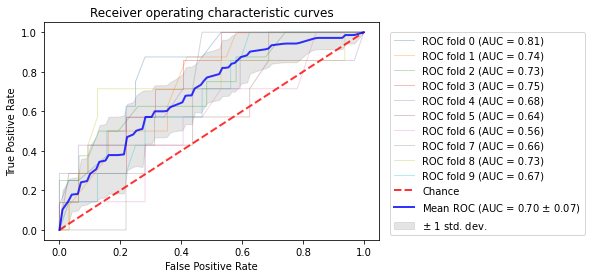

,score,mean,95% CI
0,AUC,0.70,"(0.56,0.83)"
1,accuracy,0.71,"(0.63,0.79)"
2,sensitivity,0.37,"(0,0.75)"
3,specificity,0.79,"(0.73,0.85)"
4,PPV,0.27,"(0.01,0.53)"
5,NPV,0.85,"(0.78,0.92)"


In [21]:
test_model(gs_bagging.best_estimator_, X, y)

Using best KNN as base estimator:

In [24]:
base = gs_knn.best_estimator_
bagging = Pipeline([('Bagging',BaggingClassifier(base_estimator=base, random_state=SEED))])

params_bagging = {'Bagging__n_estimators': [5,10,20,30,40,50], 'Bagging__max_samples': [0.5,0.8,1.0],
                  'Bagging__max_features': [0.5,0.8,1.0]}


gs_bagging = GridSearchCV(bagging, params_bagging, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_bagging.fit(X,y)
gs_bagging.best_params_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  92 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done 242 tasks      | elapsed:   32.8s
[Parallel(n_jobs=2)]: Done 492 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 540 out of 540 | elapsed:  1.3min finished


{'Bagging__max_features': 0.8,
 'Bagging__max_samples': 0.8,
 'Bagging__n_estimators': 40}

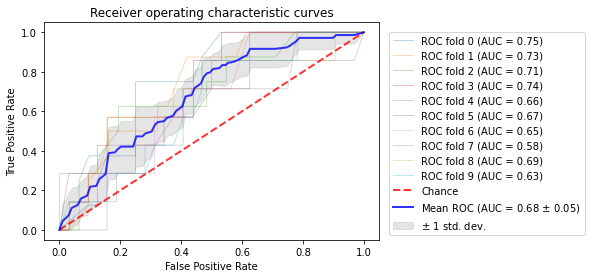

,score,mean,95% CI
0,AUC,0.68,"(0.58,0.78)"
1,accuracy,0.73,"(0.67,0.78)"
2,sensitivity,0.32,"(0.07,0.58)"
3,specificity,0.82,"(0.76,0.87)"
4,PPV,0.28,"(0.09,0.47)"
5,NPV,0.84,"(0.8,0.89)"


In [25]:
test_model(gs_bagging.best_estimator_, X, y)

### Random Forest

In [ ]:
rf = Pipeline([('RF',RandomForestClassifier(random_state=SEED))])

params_rf = {'RF__n_estimators': [10,30,50,80,100,120,150,180], 'RF__max_depth': [None,3,5],
              'RF__max_features': ['sqrt',0.8],
             'RF__class_weight': [{1:0.5},{1:1},{1:5},{1:10},{1:20}]}


gs_rf = GridSearchCV(rf, params_rf, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_rf.fit(X,y)
gs_rf.best_params_

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done 368 tasks      | elapsed:   42.3s
[Parallel(n_jobs=2)]: Done 868 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 1568 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 2400 out of 2400 | elapsed:  4.7min finished


{'RF__class_weight': {1: 5},
 'RF__max_depth': 3,
 'RF__max_features': 'sqrt',
 'RF__n_estimators': 10}

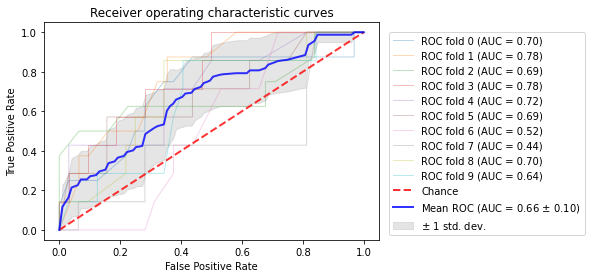

,score,mean,95% CI
0,AUC,0.67,"(0.46,0.87)"
1,accuracy,0.71,"(0.61,0.81)"
2,sensitivity,0.36,"(-0.0,0.73)"
3,specificity,0.79,"(0.73,0.85)"
4,PPV,0.28,"(0.02,0.54)"
5,NPV,0.85,"(0.77,0.92)"


In [ ]:
test_model(gs_rf.best_estimator_, X, y)

### Extra Trees

In [ ]:
et = Pipeline([('ET',ExtraTreesClassifier(random_state=SEED))])

params_et = {'ET__n_estimators': [10,30,50,80,100,120,150,180], 'ET__max_depth': [None,3,5],
              'ET__max_features': ['sqrt',0.8],
             'ET__class_weight': [{1:0.5},{1:1},{1:5},{1:10},{1:20}]}


gs_et = GridSearchCV(et, params_et, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_et.fit(X,y)
gs_et.best_params_

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 110 tasks      | elapsed:    9.1s
[Parallel(n_jobs=2)]: Done 378 tasks      | elapsed:   35.0s
[Parallel(n_jobs=2)]: Done 878 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 1578 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 2400 out of 2400 | elapsed:  3.8min finished


{'ET__class_weight': {1: 0.5},
 'ET__max_depth': 3,
 'ET__max_features': 'sqrt',
 'ET__n_estimators': 10}

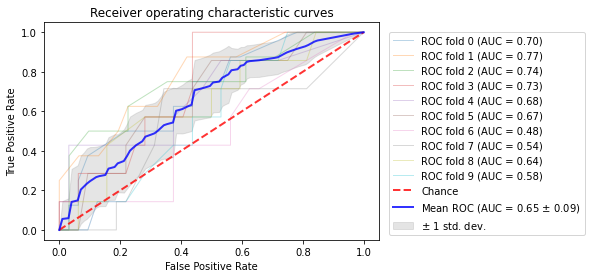

,score,mean,95% CI
0,AUC,0.65,"(0.48,0.83)"
1,accuracy,0.71,"(0.64,0.77)"
2,sensitivity,0.29,"(0,0.64)"
3,specificity,0.80,"(0.76,0.84)"
4,PPV,0.24,"(0,0.49)"
5,NPV,0.83,"(0.78,0.89)"


In [ ]:
test_model(gs_et.best_estimator_, X, y)

### AdaBoost

In [11]:
ab = Pipeline([('AB',AdaBoostClassifier(random_state=SEED))])

params_ab = {'AB__n_estimators': [5,8,10,12,15,20,30,50,80,100],
              'AB__learning_rate': [0.1,0.5,0.8,1.,1.2,1.5,2.,5.,10.]}


gs_ab = GridSearchCV(ab, params_ab, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_ab.fit(X,y)
gs_ab.best_params_

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 132 tasks      | elapsed:   16.5s
[Parallel(n_jobs=2)]: Done 900 out of 900 | elapsed:   45.4s finished


{'AB__learning_rate': 1.2, 'AB__n_estimators': 12}

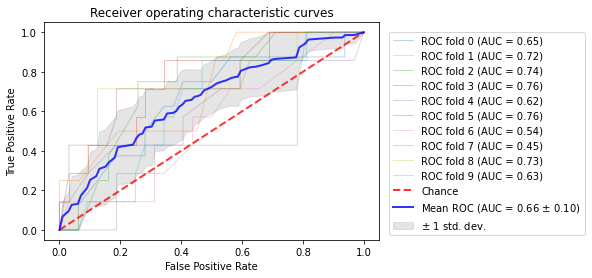

,score,mean,95% CI
0,AUC,0.66,"(0.46,0.86)"
1,accuracy,0.73,"(0.67,0.78)"
2,sensitivity,0.36,"(0,0.77)"
3,specificity,0.81,"(0.76,0.86)"
4,PPV,0.28,"(0.03,0.53)"
5,NPV,0.85,"(0.77,0.93)"


In [12]:
test_model(gs_ab.best_estimator_, X, y)

### Gradient Boosting 

In [15]:
gb = Pipeline([('GB',GradientBoostingClassifier(random_state=SEED))])

params_gb = {'GB__learning_rate': [0.01,0.05,0.08,0.1,0.12,0.15,0.2,0.5,1.0],
            'GB__n_estimators': [10,20,30,50,80,100,120,150,180],
            'GB__subsample': [0.5,0.8,1.0], 'GB__max_depth': [2,3,5]}


gs_gb = GridSearchCV(gb, params_gb, scoring='roc_auc', cv=10, n_jobs=2, verbose=1)
gs_gb.fit(X,y)
gs_gb.best_params_

Fitting 10 folds for each of 729 candidates, totalling 7290 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 202 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done 970 tasks      | elapsed:   37.4s
[Parallel(n_jobs=2)]: Done 2412 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 4210 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done 6592 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 7290 out of 7290 | elapsed:  5.0min finished


{'GB__learning_rate': 0.2,
 'GB__max_depth': 2,
 'GB__n_estimators': 30,
 'GB__subsample': 0.5}

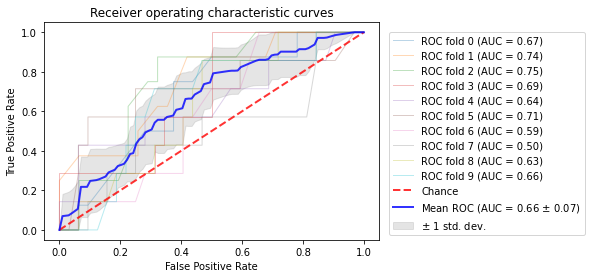

,score,mean,95% CI
0,AUC,0.66,"(0.52,0.8)"
1,accuracy,0.71,"(0.65,0.77)"
2,sensitivity,0.29,"(0.02,0.55)"
3,specificity,0.81,"(0.76,0.86)"
4,PPV,0.25,"(0.08,0.42)"
5,NPV,0.83,"(0.78,0.89)"


In [16]:
test_model(gs_gb.best_estimator_, X, y)

### Voting Classifier

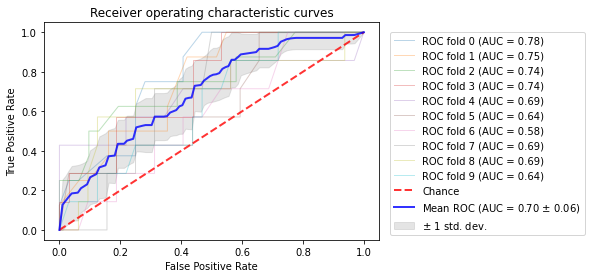

,score,mean,95% CI
0,AUC,0.70,"(0.58,0.81)"
1,accuracy,0.72,"(0.66,0.79)"
2,sensitivity,0.38,"(0.09,0.67)"
3,specificity,0.80,"(0.76,0.84)"
4,PPV,0.29,"(0.1,0.49)"
5,NPV,0.85,"(0.8,0.9)"


In [50]:
estimators = [('lr',gs_lr.best_estimator_), ('knn',gs_knn.best_estimator_), ('bagging_lr',gs_bagging.best_estimator_)]

voting = VotingClassifier(estimators=estimators, voting='soft')

test_model(voting, X, y)

### Stacking Classifier

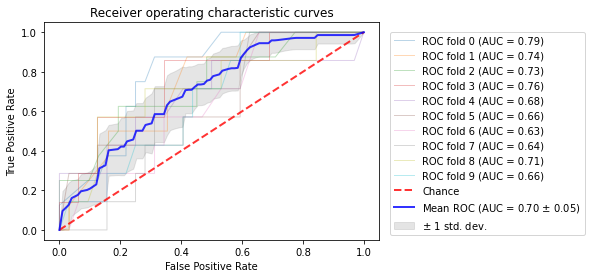

,score,mean,95% CI
0,AUC,0.70,"(0.59,0.8)"
1,accuracy,0.73,"(0.67,0.78)"
2,sensitivity,0.38,"(0.07,0.69)"
3,specificity,0.81,"(0.76,0.85)"
4,PPV,0.30,"(0.12,0.48)"
5,NPV,0.85,"(0.8,0.91)"


In [22]:
estimators = [('knn',gs_knn.best_estimator_), ('bagging_lr',gs_bagging.best_estimator_)]

stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
                              
test_model(stacking, X, y)

## Results:

|            Model            |      AUC     | accuracy | sensitivity | specificity |  PPV |  NPV |
|:---------------------------:|:------------:|:--------:|:-----------:|:-----------:|:----:|:----:|
|        Logistic Regression        | 0.69 +- 0.07 |   0.71   |     0.36    |     0.79    | 0.27 | **0.85** |
|          Linear SVC         | 0.69 +- 0.07 |   0.71   |     0.36    |     0.79    | 0.27 | **0.85** |
|             **KNN**             | **0.70 +- 0.05** |   **0.73**   |     **0.38**    |     0.81    | **0.32** | **0.85** |
|             SVC             | 0.57 +- 0.16 |   0.69   |     0.22    |     0.80    | 0.18 | 0.82 |
|         Bagging (LR)        | 0.70 +- 0.07 |   0.71   |     0.37    |     0.79    | 0.27 | **0.85** |
|        Bagging (KNN)        | 0.68 +- 0.05 |   **0.73**   |     0.32    |     **0.82**    | 0.28 | 0.84 |
|        Random Forest        | 0.66 +- 0.10 |   0.71   |     0.36    |     0.79    | 0.28 | **0.85** |
|         Extra Trees         | 0.65 +- 0.09 |   0.71   |     0.29    |     0.80    | 0.24 | 0.83 |
|           AdaBoost          | 0.66 +- 0.10 |   **0.73**   |     0.36    |     0.81    | 0.28 | **0.85** |
|        Grad. Boosting       | 0.66 +- 0.07 |   0.71   |     0.29    |     0.81    | 0.25 | 0.83 |
| Voting  (LR+KNN+bagging_lr) | 0.70 +- 0.06 |   0.72   |     **0.38**    |     0.80    | 0.29 | **0.85** |
|  Stacking  (KNN+bagging_lr) | **0.70 +- 0.05** |  **0.73**   |     0.34    |    **0.82**    | 0.30 | **0.85** |

In [13]:
# best model
clf = KNeighborsClassifier(n_neighbors=163, p=1)

In [25]:
test_model_bootstrap(clf, X, y)

,score,mean,95% CI
0,AUC,0.69,"(0.61,0.77)"
1,accuracy,0.73,"(0.69,0.77)"
2,sensitivity,0.43,"(0.27,0.58)"
3,specificity,0.80,"(0.77,0.83)"
4,PPV,0.33,"(0.22,0.43)"
5,NPV,0.86,"(0.82,0.9)"
